# Lesson 5 Assignment  - Hypothesis Simulation 
## Author - Salinee Kingbaisomboon
### UW NetID: 1950831

## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods
3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [65]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn
import statsmodels.api as sm
import scipy
import itertools
from sklearn.preprocessing import scale
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statistics import mean

import warnings

warnings.filterwarnings("ignore") # To suppress warning for Seaborn when python version is < 3.7

%matplotlib inline

In [66]:
# Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

# Read the .csv file with the pandas read_csv method
auto_price = pd.read_csv(fileName)

# Focus on the continuous variables
cols = ['price', 'bore', 'stroke', 'horsepower', 'peak-rpm']

# Remove rows with missing values, accounting for mising values coded as '?'
for column in cols:
    auto_price.loc[auto_price[column] == '?', column] = np.nan
auto_price.dropna(axis = 0, inplace = True)

## Convert those columns to numeric values
for column in cols:
    auto_price[column] = pd.to_numeric(auto_price[column])

In [3]:
# View the first 5 rows of this dataframe
auto_price.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [67]:
# View the summary statistics for this dataframe
auto_price.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.794872,98.896410,174.256923,65.886154,53.861538,2559.000000,127.938462,3.329385,3.250308,10.194974,103.271795,5099.487179,25.374359,30.841026,13248.015385
std,1.230612,6.132038,12.476443,2.132484,2.396778,524.715799,41.433916,0.271866,0.314115,4.062109,37.869730,468.271381,6.401382,6.829315,8056.330093
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.300000,64.050000,52.000000,2145.000000,98.000000,3.150000,3.110000,8.500000,70.000000,4800.000000,19.500000,25.000000,7756.500000
50%,1.000000,97.000000,173.200000,65.400000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5100.000000,25.000000,30.000000,10245.000000
75%,2.000000,102.400000,184.050000,66.900000,55.650000,2943.500000,145.500000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,35.000000,16509.000000
max,3.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000


# Declare Functions used in this assignment

In [68]:
def plot_pdf_log_normal(data, x_label):
    resolution = 1000  # How many points to sample from the PDF of the normal distribution
    x_norm = np.linspace(0, data, resolution)
    y_norm = scipy.stats.norm.pdf(
      x_norm, # Where we want to evaluate the PDF
      loc=np.mean(data), # The mean of the distribution
      scale=np.std(data)) # The std deviation of the distribution
    
    x_log_norm = np.linspace(0, data.apply(np.log), resolution)
    y_log_norm = scipy.stats.norm.pdf(
      x_log_norm, # Where we want to evaluate the PDF of log value
      loc=np.mean(data.apply(np.log)), # The mean of the distribution of log value
      scale=np.std(data.apply(np.log))) # The std deviation of the distribution of log value
    
    pyplot.subplot(2, 1, 1) # The first plot
    pyplot.hist(data, normed=True, color='white', edgecolor='black')
    pyplot.title(f'Density of {x_label} & Log-{x_label}')
    pyplot.plot(x_norm, y_norm, color='red')
    pyplot.xlabel(f'{x_label} values')
    pyplot.ylabel('Count')
    
    pyplot.subplot(2, 1, 2) # The next plot
    pyplot.hist(data.apply(np.log), normed=True, color='white', edgecolor='black')
    pyplot.plot(x_log_norm, y_log_norm, color='red')
    pyplot.ylabel('Count')

In [69]:
def compute_summary_statistics(data, label, method):
    # Compute a list of 500 sample means from sample of size 50 from the population distribution depend on the provide method
    n_replicas = 500
    n_size = 50
    
    if method == 'Classical Method':
        x_means = np.array([
            np.random.choice(data, size=n_size, replace=True).mean()
            for i in range(n_replicas)])
    elif method == 'Bootstrap Method':
        x_means = pd.Series([
            data.sample(n=n_size, replace=True).mean()
            for i in range(n_replicas)])
    elif method == 'Bayesian Method':
        # Bayesian won't replace the population after sampling. 
        # Therefore, we need to calculate the maximum times (range) we can resampling
        n_range = (int)(np.floor(len(data)/n_size))
        x_means = pd.Series([
            data.sample(n=n_size).mean()
            for i in range(n_range)])
        # Based on the UCI Machine Learning Repository Automobile Data Set's Name file, following is the possible values for each columns
        # price:                    continuous from 5118 to 45400
        # bore:                     continuous from 2.54 to 3.94
        # stroke:                   continuous from 2.07 to 4.17
        # horsepower:               continuous from 48 to 288
        # peak-rpm:                 continuous from 4150 to 6600
        if label == 'price':
            p = np.linspace(5118, 45400, num=n_replicas) # prio disribution for price
        elif label == 'bore':
            p = np.linspace(2.54, 3.94, num=n_replicas) # prio disribution for bore
        elif label == 'stroke':
            p = np.linspace(2.07, 4.17, num=n_replicas) # prio disribution for stroke
        elif label == 'horsepower':
            p = np.linspace(48, 288, num=n_replicas) # prio disribution for horsepower
        elif label == 'peak-rpm':
            p = np.linspace(4150, 6600, num=n_replicas) # prio disribution for peak-rpm
        
        # prior distribution (normal), sd = 5 (dummy prior since we don't know)
        pp = scipy.stats.norm.pdf(p, loc=x_means.mean(), scale=5) 
        pp = pp / pp.sum() # normalize that prior

        like = normal_like(p, x_means) # compute the likelihood
        post = posterior(pp, like) # compute the posterior distribution
    
    pop_mean = np.mean(x_means) # sample mean
    pop_std = np.std(x_means) # sample standard distribution
    
    print(f'\033[1m\033[4mSummary Statistics ({method}) of: {label}\033[0m')
    print('Estimated mean (%.3f) vs actual mean (%.3f)' % (pop_mean, np.mean(data)))
    print('Estimated s.d. (%.3f) vs actual s.d. (%.3f)' % (pop_std, np.std(data)))
    print('-----------------------------------------------------')
    
    if method == 'Bayesian Method':
        return pop_mean, pop_std, p, post
    else:
        return pop_mean, pop_std

In [70]:
def compute_confidence_intervals(data, pop_mean, pop_std, label, method, p = [], post = []):
    # Compute the 95% confident interval depend on the provide method
    if method == 'Bayesian Method':
        num_samples = 100000
        upper_q=.975
        lower_q=.025
        samples = np.random.choice(p, size=num_samples, replace=True, p=post)
        ci = scipy.percentile(samples, [lower_q*100, upper_q*100])
        interval = upper_q - lower_q
        print(f'\033[1m\033[4m95% Credible Intervals ({method}) of: {label}\033[0m')
        print('The %.3f credible interval is %.3f to %.3f' % (interval, ci[0], ci[1]))
        print('-----------------------------------------------------')
    else:    
        alpha = 0.95
        half_width = scipy.stats.norm.ppf((1 + alpha)/2, loc=pop_mean, scale=pop_std) - pop_mean
        ci_low = pop_mean - half_width
        ci_high = pop_mean + half_width
        print(f'\033[1m\033[4m95% Confident Intervals ({method}) of: {label}\033[0m')
        print('The half width is %.2f' % half_width)
        print('The actual mean is %.2f' % np.mean(data))
        print('The %.2f level CI is (%.2f , %.2f)' % (alpha, ci_low, ci_high))
        print('-----------------------------------------------------')

In [71]:
# Function to plot the histogram with mean value (as a red vertcal line)
def hist_plot(vec, bins):
    pyplot.hist(vec, bins = bins)
    pyplot.axvline(np.mean(vec), color = 'red') # Add a vertical line across the axes
    pyplot.ylabel('Frequency')
    pyplot.xlabel('Value')

In [72]:
# Function to plot the histogram with confident inverval as the red vertical lines
def hist_mean_ci(vec, t_test, bins):
    upper = np.mean(vec) + t_test[5] - t_test[1]
    lower = np.mean(vec) + t_test[4] - t_test[1]
    pyplot.hist(vec, bins = bins)
    pyplot.axvline(np.mean(vec), color = 'red')
    pyplot.axvline(upper, color = 'red', linestyle='--')
    pyplot.axvline(lower, color = 'red', linestyle='--')
    pyplot.ylabel('Frequency')
    pyplot.xlabel('Value')

In [73]:
# Function to calculate the t-test statistics
def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean() # the mean different of two samples

    res = scipy.stats.ttest_ind(a, b, equal_var=False) # return The calculated t-statistic and the p-value
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') # computed the confident interval
    degfree = means.dof_satt() # use Welch’s T-test to get the degree of freedom

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI'] # upper & local confident interval
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index) 

In [74]:
# Function to plot the histogram of the t-test
def plot_t(a, b, t_test, cols, nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    pyplot.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    pyplot.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    pyplot.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

In [75]:
# Function to caulculate the posterios distribution
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

In [76]:
# Compute the likelihood of the normal distributipon
def normal_like(p, x):
    variance = np.std(x)**2 # sigma square (impirical standard deviation)
    x_mean = np.asarray(x).mean() # mean
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance)) # normal distribution probability density function
    return l / l.sum() # normalize that PDF

In [77]:
def plot_ci(p1, p2, post1, post2, num_samples, lower_q, upper_q, title):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the calculation simple
    ## Compute a large sample by resampling with replacement
    
    # Sample 1
    samples1 = np.random.choice(p1, size=num_samples, replace=True, p=post1)
    ci1 = scipy.percentile(samples1, [lower_q*100, upper_q*100]) # compute the quantiles
    # Sample 2
    samples2 = np.random.choice(p2, size=num_samples, replace=True, p=post2)
    ci2 = scipy.percentile(samples2, [lower_q*100, upper_q*100])# compute the quantiles
    
    interval = upper_q - lower_q
    
    pyplot.title('Posterior density with %.3f credible interval between %s' % (interval,title))
    pyplot.xlabel('Parameter value')
    pyplot.ylabel('Density')
    
    pyplot.subplot(2, 1, 1) # The first plot
    pyplot.plot(p1, post1, color='blue')
    pyplot.axvline(x=ci1[0], color='red')
    pyplot.axvline(x=ci1[1], color='red')
    
    pyplot.subplot(2, 1, 2) # The next plot
    pyplot.plot(p2, post2, color='green')
    pyplot.axvline(x=ci2[0], color='yellow')
    pyplot.axvline(x=ci2[1], color='yellow')

## 1. Identify a likely distribution for price and several other features
In this assignment, I'll primary focus on the continuous random variables. Aside from the **price**, I also pick several other features such as **bore**, **stroke**, **horsepower** and **peak-rpm**.

Based on the UCI Machine Learning Repository Automobile Data Set's Name file (https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names), I listed all the possible values for each selected columns as the following:
1. **price**:                    continuous from 5118 to 45400
2. **bore**:                     continuous from 2.54 to 3.94
3. **stroke**:                   continuous from 2.07 to 4.17
4. **horsepower**:               continuous from 48 to 288
5. **peak-rpm**:                 continuous from 4150 to 6600

**Note:** Based on Lesson 3, those quantities one can mesure in only defined range $0 \lt x \le \infty$. Therefore, we pretty sure that some of these features will have **Log-Normal Distribution**.

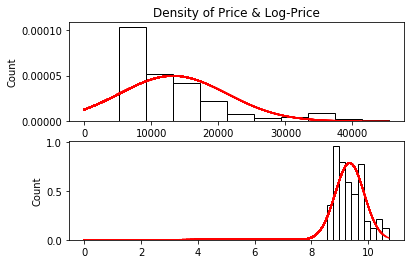

In [78]:
# Plot the histogram of the price & log-price columns
plot_pdf_log_normal(auto_price.loc[:,'price'], 'Price')

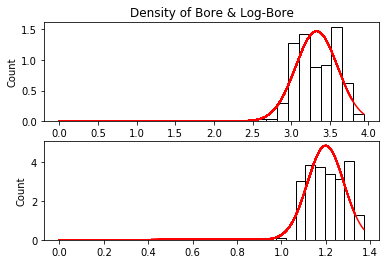

In [79]:
# Plot the histogram of the bore & log-bore columns
plot_pdf_log_normal(auto_price.loc[:,'bore'], 'Bore')

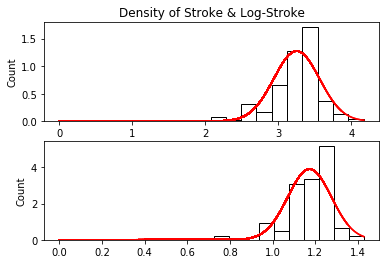

In [80]:
# Plot the histogram of the stroke & log-stroke column
plot_pdf_log_normal(auto_price.loc[:,'stroke'], 'Stroke')

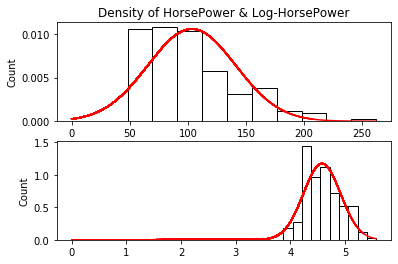

In [81]:
# Plot the histogram of the horsepower & log-horsepower column
plot_pdf_log_normal(auto_price.loc[:,'horsepower'], 'HorsePower')

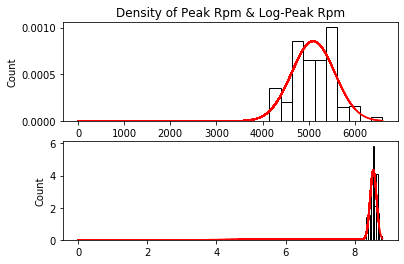

In [82]:
# Plot the histogram of the peak-rpm & log-peak-rpm column
plot_pdf_log_normal(auto_price.loc[:,'peak-rpm'], 'Peak Rpm')

***
### Summary

- **Log-Normal Distribution:** We found that **price** and **horsepower** columns have Log-Normal Distribution. This may be due to the wide unit range of values.
- **Normal Distribution:** We founc that **bore**, **stroke** and **peak-rpm** columns have Normal Distribution. This may be due to the small range of values.
***

## 2. Compute basic summary statistics by both Classical, Bootstrap and Bayesian methods

### a) Classical Method

In [83]:
# Summary Statistic (classical method) of several features
classical_pop_means = []
classical_pop_stds = []
for column in cols:
    mean, std = compute_summary_statistics(auto_price.loc[:,column], column, 'Classical Method')
    classical_pop_means.append(mean)
    classical_pop_stds.append(std)

Summary Statistics (Classical Method) of: price
Estimated mean (13248.157) vs actual mean (13248.015)
Estimated s.d. (1205.089) vs actual s.d. (8035.646)
-----------------------------------------------------
Summary Statistics (Classical Method) of: bore
Estimated mean (3.328) vs actual mean (3.329)
Estimated s.d. (0.036) vs actual s.d. (0.271)
-----------------------------------------------------
Summary Statistics (Classical Method) of: stroke
Estimated mean (3.251) vs actual mean (3.250)
Estimated s.d. (0.042) vs actual s.d. (0.313)
-----------------------------------------------------
Summary Statistics (Classical Method) of: horsepower
Estimated mean (103.353) vs actual mean (103.272)
Estimated s.d. (5.567) vs actual s.d. (37.773)
-----------------------------------------------------
Summary Statistics (Classical Method) of: peak-rpm
Estimated mean (5099.890) vs actual mean (5099.487)
Estimated s.d. (66.471) vs actual s.d. (467.069)
------------------------------------------------

### b) Bootstrap Method

In [84]:
# Summary Statistic (bootstrap method) of several features
bootstrap_pop_means = []
bootstrap_pop_stds = []
for column in cols:
    mean, std = compute_summary_statistics(auto_price.loc[:,column], column, 'Bootstrap Method')
    bootstrap_pop_means.append(mean)
    bootstrap_pop_stds.append(std)

Summary Statistics (Bootstrap Method) of: price
Estimated mean (13187.534) vs actual mean (13248.015)
Estimated s.d. (1198.205) vs actual s.d. (8035.646)
-----------------------------------------------------
Summary Statistics (Bootstrap Method) of: bore
Estimated mean (3.327) vs actual mean (3.329)
Estimated s.d. (0.041) vs actual s.d. (0.271)
-----------------------------------------------------
Summary Statistics (Bootstrap Method) of: stroke
Estimated mean (3.248) vs actual mean (3.250)
Estimated s.d. (0.045) vs actual s.d. (0.313)
-----------------------------------------------------
Summary Statistics (Bootstrap Method) of: horsepower
Estimated mean (102.939) vs actual mean (103.272)
Estimated s.d. (5.130) vs actual s.d. (37.773)
-----------------------------------------------------
Summary Statistics (Bootstrap Method) of: peak-rpm
Estimated mean (5095.598) vs actual mean (5099.487)
Estimated s.d. (65.623) vs actual s.d. (467.069)
------------------------------------------------

### c) Bayesian Method

In [85]:
# Summary Statistic (Bayesian method) of several features
bayesian_pop_means = []
bayesian_pop_stds = []
bayesian_pop_p = []
bayesian_pop_posterior = []
for column in cols:
    mean, std, p, post = compute_summary_statistics(auto_price.loc[:,column], column, 'Bayesian Method')
    bayesian_pop_means.append(mean)
    bayesian_pop_stds.append(std)
    bayesian_pop_p.append(p)
    bayesian_pop_posterior.append(post)

Summary Statistics (Bayesian Method) of: price
Estimated mean (13959.180) vs actual mean (13248.015)
Estimated s.d. (847.693) vs actual s.d. (8035.646)
-----------------------------------------------------
Summary Statistics (Bayesian Method) of: bore
Estimated mean (3.346) vs actual mean (3.329)
Estimated s.d. (0.021) vs actual s.d. (0.271)
-----------------------------------------------------
Summary Statistics (Bayesian Method) of: stroke
Estimated mean (3.275) vs actual mean (3.250)
Estimated s.d. (0.011) vs actual s.d. (0.313)
-----------------------------------------------------
Summary Statistics (Bayesian Method) of: horsepower
Estimated mean (108.973) vs actual mean (103.272)
Estimated s.d. (5.940) vs actual s.d. (37.773)
-----------------------------------------------------
Summary Statistics (Bayesian Method) of: peak-rpm
Estimated mean (5100.333) vs actual mean (5099.487)
Estimated s.d. (30.652) vs actual s.d. (467.069)
-----------------------------------------------------


***
### Summary

- **Mean:** We found that **All three methods** yield similar mean values for each features.
- **Standard Deviation:** We found that **Bayesian method** yeild the smallest value compared with other two methods.
***

## 3. Compute confidence intervals for the above summary statistics by Classical, Bootstrap and Bayesian methods

### a) Classical Method

In [87]:
i = 0
for column in cols: # loop through all the mean and sd value's arrays coomputed from the summary statistics section
    compute_confidence_intervals(auto_price.loc[:,column], classical_pop_means[i], classical_pop_stds[i], column, 'Classical Method')
    i += 1

95% Confident Intervals (Classical Method) of: price
The half width is 2361.93
The actual mean is 13248.02
The 0.95 level CI is (10886.23 , 15610.09)
-----------------------------------------------------
95% Confident Intervals (Classical Method) of: bore
The half width is 0.07
The actual mean is 3.33
The 0.95 level CI is (3.26 , 3.40)
-----------------------------------------------------
95% Confident Intervals (Classical Method) of: stroke
The half width is 0.08
The actual mean is 3.25
The 0.95 level CI is (3.17 , 3.33)
-----------------------------------------------------
95% Confident Intervals (Classical Method) of: horsepower
The half width is 10.91
The actual mean is 103.27
The 0.95 level CI is (92.44 , 114.26)
-----------------------------------------------------
95% Confident Intervals (Classical Method) of: peak-rpm
The half width is 130.28
The actual mean is 5099.49
The 0.95 level CI is (4969.61 , 5230.17)
-----------------------------------------------------


### b) Bootstrap Method

In [88]:
i = 0
for column in cols: # loop through all the mean and sd value's arrays coomputed from the summary statistics section
    compute_confidence_intervals(auto_price.loc[:,column], bootstrap_pop_means[i], bootstrap_pop_stds[i], column, 'Bootstrap Method')
    i += 1

95% Confident Intervals (Bootstrap Method) of: price
The half width is 2348.44
The actual mean is 13248.02
The 0.95 level CI is (10839.10 , 15535.97)
-----------------------------------------------------
95% Confident Intervals (Bootstrap Method) of: bore
The half width is 0.08
The actual mean is 3.33
The 0.95 level CI is (3.25 , 3.41)
-----------------------------------------------------
95% Confident Intervals (Bootstrap Method) of: stroke
The half width is 0.09
The actual mean is 3.25
The 0.95 level CI is (3.16 , 3.34)
-----------------------------------------------------
95% Confident Intervals (Bootstrap Method) of: horsepower
The half width is 10.05
The actual mean is 103.27
The 0.95 level CI is (92.88 , 112.99)
-----------------------------------------------------
95% Confident Intervals (Bootstrap Method) of: peak-rpm
The half width is 128.62
The actual mean is 5099.49
The 0.95 level CI is (4966.98 , 5224.22)
-----------------------------------------------------


### c) Bayesian Method

In [89]:
i = 0
for column in cols: # loop through all the mean, sd, prior and posteria distribution value's arrays coomputed from the summary statistics section
    compute_confidence_intervals(auto_price.loc[:,column], bayesian_pop_means[i], bayesian_pop_stds[i], column, 'Bayesian Method', bayesian_pop_p[i], bayesian_pop_posterior[i])
    i += 1

95% Credible Intervals (Bayesian Method) of: price
The 0.950 credible interval is 13997.800 to 13997.800
-----------------------------------------------------
95% Credible Intervals (Bayesian Method) of: bore
The 0.950 credible interval is 3.323 to 3.370
-----------------------------------------------------
95% Credible Intervals (Bayesian Method) of: stroke
The 0.950 credible interval is 3.261 to 3.286
-----------------------------------------------------
95% Credible Intervals (Bayesian Method) of: horsepower
The 0.950 credible interval is 103.311 to 114.373
-----------------------------------------------------
95% Credible Intervals (Bayesian Method) of: peak-rpm
The 0.950 credible interval is 5092.685 to 5107.415
-----------------------------------------------------


***
### Summary

- **For Classical & Bootstrap Methods:** Both yield the similar values of 95% Confident Intervals
- **For Bayesian Method:** The 95% Credible Intervals slightly shifted to the right compared with the 95% Confident Intervals from Classical & Bootstrap Methods.
***

## 4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant
I decide to pick the comparison pair between **price** and **horsepower** since both of them have Log-Normal Distribution. We want to test the **Central Limit Theorem** which stated that after sampling a population many times, the distribution of means of all samples are normally distributed, regardless of the population distribution.

### a) Classical tests

In [90]:
# Compute a list of 1000 sample means from sample of size 100 from the population distribution for both price and horsepower
price_classical_means_scale = scale(np.array([
    np.random.choice(auto_price.loc[:,'price'], size=100, replace=True).mean()
    for i in range(1000)])) # scale the price's mean
horsepower_classical_means_scale = scale(np.array([
    np.random.choice(auto_price.loc[:,'horsepower'], size=100, replace=True).mean()
    for i in range(1000)])) # scale the horsepower's mean

# Compute the t-statistics between price's means & horsepower's scaled mean
test_price_horsepower_classical = t_test(price_classical_means_scale, horsepower_classical_means_scale, 0.05)
test_price_horsepower_classical

DegFreedom    1.998000e+03
Difference   -2.572165e-15
Statistic    -5.748659e-14
PValue        1.000000e+00
Low95CI      -8.774927e-02
High95CI      8.774927e-02
dtype: float64

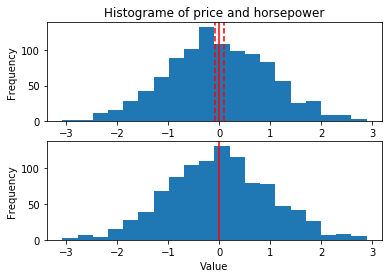

In [51]:
plot_t(price_classical_means_scale, horsepower_classical_means_scale, test_price_horsepower_classical, ['price', 'horsepower']) 

#### Examine the results:
1. The t-statistic is small, the **p-value is large**, and the **confidence interval of the difference of the means overlap zero**. We have to **accept the null hypothesis** that both means are the same between price and horsepower. The different in means are not significant.
2. The **mean of the second group (gas) falls inside the confidence interval**, confirming that **there is a high chance that the difference in means is from random variation alone**.
3. This prove the Central Limit Theorem.

### b) Tukey’s Honest Significant Differences (HSD)

In [91]:
# Since pairwise_tukeyhsd method from Stats Models need three groups as a minimum
# I decide to add bore's feature to the plot
bore_classical_means_scale = scale(np.array([
    np.random.choice(auto_price.loc[:,'bore'], size=100, replace=True).mean()
    for i in range(1000)]).tolist()) # scale the bore's mean

In [92]:
# Concatenate those three features (1 = price, 2 = horsepower, 3 = bore) with the group number into a data frame
df = pd.DataFrame({'vals': np.concatenate((price_classical_means_scale, horsepower_classical_means_scale, bore_classical_means_scale)).flatten(),
                   'group_num': ['1'] * 1000 + ['2'] * 1000 + ['3'] * 1000})
df

,vals,group_num
0,0.122123,1
1,1.278934,1
2,-0.500726,1
3,-0.220700,1
4,-0.271115,1
...,...,...
2995,0.309120,3
2996,0.471517,3
2997,-1.307629,3
2998,1.095842,3


In [93]:
# Compute Turkey's ANOVA
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2      0.0   0.9 -0.1049 0.1049  False
     1      3      0.0   0.9 -0.1049 0.1049  False
     2      3      0.0   0.9 -0.1049 0.1049  False
--------------------------------------------------


Text(0.5, 1.0, 'Box plot of variables')

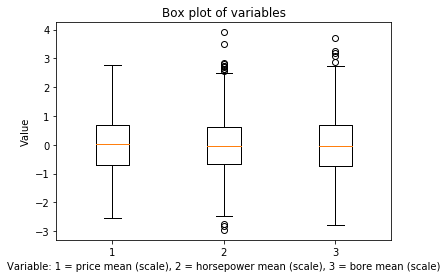

In [94]:
pyplot.boxplot([price_classical_means_scale, horsepower_classical_means_scale, bore_classical_means_scale])
pyplot.ylabel('Value')
pyplot.xlabel('Variable: 1 = price mean (scale), 2 = horsepower mean (scale), 3 = bore mean (scale)')
pyplot.title('Box plot of variables')

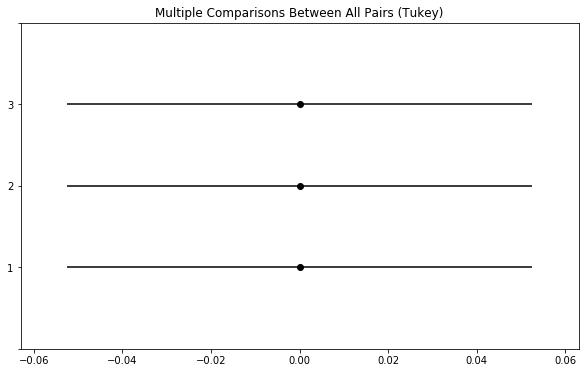

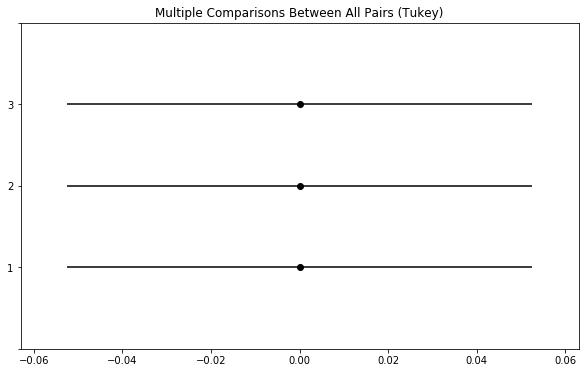

In [95]:
Tukey_HSD.plot_simultaneous()

***
#### Examine the results:
1. **From the test result plots:** We found that the different in mean between **group 1 (price), group 2 (horsepower) and group 3 (bore)** are not significant at the confidence level since all confidence intervals are overlapped at 95% confident level.
2. This prove the Central Limit Theorem.
***

### c) Bootstrap methods

In [96]:
# Compute a list of 1000 sample means from sample of size 100 from the population distribution for both price and horsepower
price_bootstrap_means = pd.Series([
            auto_price.loc[:,'price'].sample(n=100, replace=True).mean()
            for i in range(1000)])
horsepower_bootstrap_means = pd.Series([
            auto_price.loc[:,'horsepower'].sample(n=100, replace=True).mean()
            for i in range(1000)]) 

price_bootstrap_means_scale = scale(price_bootstrap_means) # scale the price's mean
horsepower_bootstrap_means_scale = scale(horsepower_bootstrap_means) # scale the horsepower's mean

# Compute the t-statistics between price's means & horsepower's scaled mean
test_price_horsepower_bootstrap = t_test(price_bootstrap_means_scale, horsepower_bootstrap_means_scale, 0.05)
test_price_horsepower_bootstrap

DegFreedom    1.998000e+03
Difference    2.630784e-15
Statistic     5.879671e-14
PValue        1.000000e+00
Low95CI      -8.774927e-02
High95CI      8.774927e-02
dtype: float64

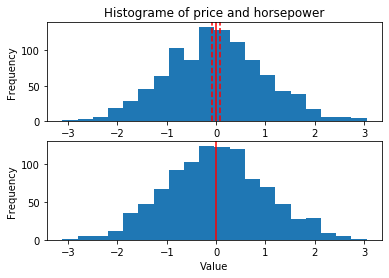

In [97]:
plot_t(price_bootstrap_means_scale, horsepower_bootstrap_means_scale, test_price_horsepower_bootstrap, ['price', 'horsepower']) 

#### Examine the results:
1. The t-statistic is small, the **p-value is large**, and the **confidence interval of the difference of the means overlap zero**. We have to **accept the null hypothesis** that both means are the same between price and horsepower. The different in means are not significant.
2. The **mean of the second group (gas) falls inside the confidence interval**, confirming that **there is a high chance that the difference in means is from random variation alone**.
3. This prove the Central Limit Theorem.

### d) Bayesian model

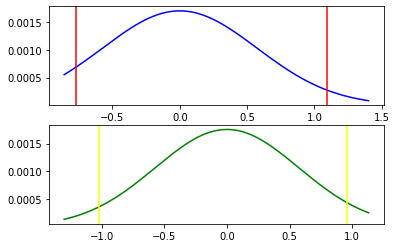

In [64]:
n_size = 50

# Bayesian won't replace the population after sampling. 
# Therefore, we need to calculate the maximum times (range) we can resampling
n_range = np.floor(len(auto_price)/n_size)

price_data = auto_price.loc[:,'price'].copy()
horsepower_data = auto_price.loc[:,'horsepower'].copy()

price_bayesian_means = pd.Series([
            price_data.sample(n=n_size).mean()
            for i in range((int)(n_range))]) # resampling without replacement
horsepower_bayesian_means = pd.Series([
            horsepower_data.sample(n=n_size).mean()
            for i in range((int)(n_range))]) # resampling without replacement

price_bayesian_means_scale = scale(price_bayesian_means) # scale the price's mean
horsepower_bayesian_means_scale = scale(horsepower_bayesian_means) # scale the horsepower's mean

# Prior Distribution of Price & Horsepower
p_price = np.linspace(min(price_bayesian_means_scale), max(price_bayesian_means_scale), num=1000)
p_horsepower = np.linspace(min(horsepower_bayesian_means_scale), max(horsepower_bayesian_means_scale), num=1000)

# Normalized Prior Distribution of Price
pp_price = scipy.stats.norm.pdf(p_price, loc=price_bayesian_means_scale.mean(), scale=5) # prior distribution (normal), sd = 5 (uninformative prior)
pp_price = pp_price / pp_price.sum() # normalize that prior

# Normalized Prior Distribution of Price
pp_horsepower = scipy.stats.norm.pdf(p_horsepower, loc=horsepower_bayesian_means_scale.mean(), scale=5) # prior distribution (normal), sd = 5 (uninformative prior)
pp_horsepower = pp_horsepower / pp_horsepower.sum() # normalize that prior

# Likelihood & Posterior of Price
like_price_bayesian = normal_like(p_price, price_bayesian_means_scale)
post_price_bayesian = posterior(pp_price, like_price_bayesian)

# Likelihood & Posterior of Horsepower
like_horsepower_bayesian = normal_like(p_horsepower, horsepower_bayesian_means_scale)
post_horsepower_bayesian = posterior(pp_horsepower, like_horsepower_bayesian)

# Plotting the Posterior distributions and CIs for Price & Horsepower
plot_ci(p_price, p_horsepower, post_price_bayesian,  post_horsepower_bayesian, 1000, lower_q=.025, upper_q=.975, title='Price and Horse Power')

***
#### Examine the results:
1. **From the test result plots:** We found that the different in mean between **price (plot 1) and horsepower (plot 2)** are not significant at the confidence level since the credible intervals are overlapped at 95% confident level.
2. This prove the Central Limit Theorem.
***